# 5. Pretraining on unlabeled data

Topics:
- evaluating the quality of generated text
- load pretrained weights

In [17]:
from dataclasses import asdict
from typing import Optional

import torch 
import tiktoken
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from gpt import GPTModel, GPTConfig, generate_text_simple, create_dataloader_v1

## 5.1 Evaluating generative text models

### 5.1.1 Using GPT to generate text

In [2]:
GPT_CONFIG_124M = GPTConfig(
    vocabulary_size=50257,
    context_length=256,
    embedding_dim=768,
    num_heads=12,
    num_transformers=12,
    dropout_rate=0.1,
    qkv_bias=False
)

torch.manual_seed(123)
model = GPTModel(**asdict(GPT_CONFIG_124M))
model.eval()

GPTModel(
  (token_embedding_layer): Embedding(50257, 768)
  (position_embedding_layer): Embedding(256, 768)
  (embedding_dropout_layer): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerB

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


start_tokens = "every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    token_ids=text_to_token_ids(start_tokens, tokenizer),
    num_new_tokens=10,
    context_size=GPT_CONFIG_124M.context_length
)
print(f"Output text:\n {token_ids_to_text(token_ids, tokenizer)}")

Output text:
 every effort moves you rentingetic minion mobilized Macicone heterogeneity achaRAM


### 5.1.2 Calculating the text generation loss

In [5]:
inputs = torch.tensor([[16833, 3626, 6100],  # every effort moves
                       [40,    1107, 588]])  # I really like

targets = torch.tensor([[3626, 6100, 435],   # effort moves you
                        [1107, 588, 11311]]) # really like chocolate

with torch.no_grad():
    logits = model(inputs)

probabilities = torch.softmax(logits, dim=-1)
print(probabilities.shape)

token_ids = torch.argmax(probabilities, dim=-1, keepdim=True)
print(f"Token IDs:\n {token_ids}")

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves al
Outputs batch 1:  Armed heNetflix


In [6]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

perplexity = torch.exp(loss)
print(perplexity)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.8122)
tensor(49623.7266)


### 5.1.3 Calculating the training and validation set losses

In [7]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


In [8]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
validation_data = text_data[split_idx:]

In [9]:
train_loader = create_dataloader_v1(
    train_data,
    window_length=GPT_CONFIG_124M.context_length,
    stride=GPT_CONFIG_124M.context_length,
    batch_size=2,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

validation_loader = create_dataloader_v1(
    validation_data,
    window_length=GPT_CONFIG_124M.context_length,
    stride=GPT_CONFIG_124M.context_length,
    batch_size=2,
    shuffle=False,
    drop_last=False,
    num_workers=0,
)


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    logits = model(input_batch)
    logits_flat = logits.flatten(0, 1)

    target_batch = target_batch.to(device)
    target_flat = target_batch.flatten()

    loss = torch.nn.functional.cross_entropy(logits_flat, target_flat)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches: Optional[int] = None):
    """Calculates the average loss of the first n batches in the data loader."""
    if len(data_loader) == 0:
        return float("nan")
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    total_loss = 0.
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    validation_loss = calc_loss_loader(validation_loader, model, device)
print(f"Training loss: {train_loss}")
print(f"Validation loss: {validation_loss}")

Training loss: 5.939951525794135
Validation loss: 6.85154390335083


## 5.2 Training an LLM

In [15]:
def evaluate_model(
    model, 
    train_loader, validation_loader, 
    device, 
    num_batches: int
):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches)
        validation_loss = calc_loss_loader(validation_loader, model, device, num_batches)
    model.train()
    return train_loss, validation_loss


def generate_and_print_sample(model: GPTModel, tokenizer, device, start_tokens: str):
    model.eval()
    context_size = model.position_embedding_layer.weight.shape[0]
    token_ids = text_to_token_ids(start_tokens, tokenizer).to(device)
    with torch.no_grad():
        generated_token_ids = generate_text_simple(
            model, token_ids, num_new_tokens=50, context_size=context_size
        )
    generated_tokens = token_ids_to_text(generated_token_ids, tokenizer)
    print(generated_tokens.replace("\n", " "))
    model.train()


def train_model_simple(
    model: GPTModel,
    train_loader, validation_loader, 
    optimizer, device, num_epochs, 
    eval_freq: int, eval_n_batches: int, 
    start_tokens: str, tokenizer
):
    (
        train_losses, 
        validation_losses, 
        num_tokens_seen_list
    ) = [], [], []
    num_tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            # Reset loss gradients from the previous batch iteration
            optimizer.zero_grad()  
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            num_tokens_seen += input_batch.numel()
            global_step += 1

            # Evaluate model at specified frequency
            if global_step % eval_freq == 0:
                train_loss, validation_loss = evaluate_model(
                    model, 
                    train_loader, 
                    validation_loader, 
                    device, 
                    eval_n_batches
                )
                train_losses.append(train_loss)
                validation_losses.append(validation_loss)
                num_tokens_seen_list.append(num_tokens_seen)
                print(
                    f"Ep {epoch + 1} (Step {global_step: 06d}): "
                    f"Train loss {train_loss:.3f}, Validation loss {validation_loss:.3f}"
                )

        generate_and_print_sample(model, tokenizer, device, start_tokens)

    return train_losses, validation_losses, num_tokens_seen_list

In [19]:
torch.manual_seed(123)
model = GPTModel(**asdict(GPT_CONFIG_124M))
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, validation_losses, num_tokens_seen_list = train_model_simple(
    model, 
    train_loader, validation_loader, 
    optimizer, device, num_epochs, 
    eval_freq=5, eval_n_batches=5, 
    start_tokens="Every effort moves you", 
    tokenizer=tokenizer
)

Ep 1 (Step  00000): Train loss 10.948, Validation loss 10.935
Ep 1 (Step  00005): Train loss 9.748, Validation loss 9.768
Every effort moves you his hisy hisyy hisy hisyyyyyyyyyyyyyyyy hisyy hisy hisyy his hisy hisy hisy hisyyy hisyyy hisy
Ep 2 (Step  00010): Train loss 8.108, Validation loss 8.308
Ep 2 (Step  00015): Train loss 6.912, Validation loss 7.200
Every effort moves you his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his his
Ep 3 (Step  00020): Train loss 6.334, Validation loss 6.735
Ep 3 (Step  00025): Train loss 6.104, Validation loss 6.632
Every effort moves you the... the the. the the the the.... the the the the the the. the. the the the the. the the. the the the the. the. the the the the. the the. the the the
Ep 4 (Step  00030): Train loss 6.062, Validation loss 6.673
Ep 4 (Step  00035): Train loss 6.065, Validation loss 6.741
Ev

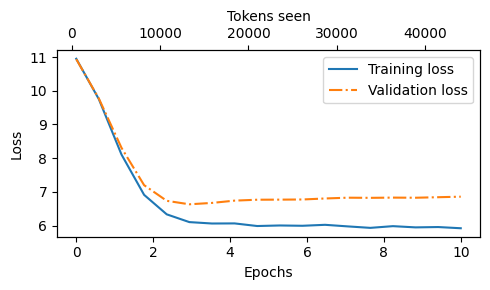

In [20]:
def plot_losses(epochs_seen, tokens_seen, train_losses, validation_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, 
        validation_losses, 
        linestyle="-.", 
        label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
    
num_epochs_list = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(num_epochs_list, num_tokens_seen_list, train_losses, validation_losses)

## 5.3 Decoding strategies to control randomness

In [25]:
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    token_ids=text_to_token_ids("Every effort moves you", tokenizer),
    num_new_tokens=25,
    context_size=GPT_CONFIG_124M.context_length
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you..,......,,,...,,










In [26]:
def generate(
    model, 
    token_ids, 
    num_new_tokens, 
    context_size, 
    temperature=0.0, 
    top_k=None, 
    eos_id=None
):
    for _ in range(num_new_tokens):
        token_ids_in_context = token_ids[:, -context_size:]
        
        with torch.no_grad():
            logits = model(token_ids_in_context)
        logits = logits[:, -1, :]
        
        if top_k is not None:
            top_k_logits, _ = torch.topk(logits, top_k)
            kth_logit = top_k_logits[:, -1]
            logits = torch.where(
                logits < kth_logit, 
                torch.tensor(float("-inf")).to(logits.device), 
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probabilities = torch.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
        else:
            next_token_id = torch.argmax(logits, dim=-1, keepdim=True)
        
        if next_token_id == eos_id:
            break
        
        token_ids = torch.cat((token_ids, next_token_id), dim=1)
        
    return token_ids

In [29]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    token_ids=text_to_token_ids("Every effort moves you", tokenizer),
    num_new_tokens=15,
    context_size=GPT_CONFIG_124M.context_length,
    top_k=25,
    temperature=1.4,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you't I. I it a,. his that " my-- "



## 5.4 Loading and saving model weights in PyTorch

## 5.5 Loading pretrained weights from OpenAI

In [34]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x37f6dcb20>)

In [35]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [36]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "num_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "num_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "num_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "num_heads": 25},
}

In [53]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_fe

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(
            f"Shape mismatch. Left: {left.shape}, Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))


import numpy as np

def load_weights_into_gpt(gpt, params):           #1
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):     #2
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

        gpt.trf_blocks[b].attn.W_query.weight = assign(gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(gpt.trf_blocks[b].attn.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(gpt.trf_blocks[b].attn.W_value.bias, v_b)

        gpt.trf_blocks[b].attn.out_projection.weight = assign(
            gpt.trf_blocks[b].attn.out_projection.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].attn.out_projection.bias = assign(
            gpt.trf_blocks[b].attn.out_projection.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device)
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    token_ids=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    num_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


